## Goal:
Find the type of **relationship** between named entities in a sentence

### Relationship types (based on the 17 relationships from ACE relation extraction task)

* *Person-Social*-Family
* *Person-Social*-Business
* *Person-Social*-Lasting Personal
* *Physical*-Located
* *Physical*-Near
* ...

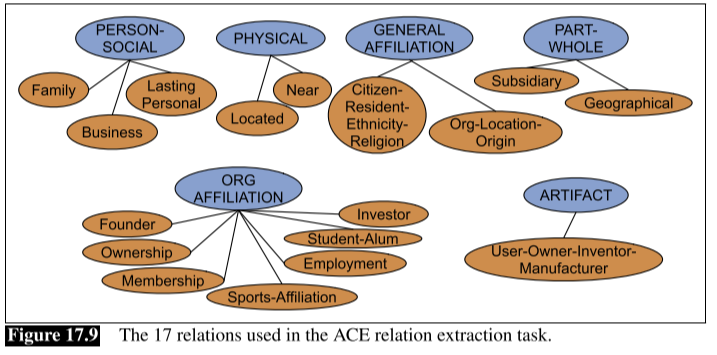

## Approach


1. Create seed pattern for relationships (_child-of_, _parent-of_)
2. Run NER-Tagger on large text
3. Extract features (between words, pos-tags etc.)
4. Create feature vectors
5. Train model



In [1]:
import re
import spacy

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tag import pos_tag
from nltk.tag import StanfordNERTagger

model = '../models/dewac_175m_600.crf.ser.gz'
#model = '../models/hgc_175m_600.crf.ser.gz'
#model = '../models/german.conll.germeval2014.hgc_175m_600.crf.ser.gz'

st = StanfordNERTagger(model,
                       '../models/stanford-ner.jar',
                       encoding='utf-8')

nlp = spacy.load('de')

c:\program files\python\lib\site-packages\nltk\tag\stanford.py:183: DeprecationWarning: 
The StanfordTokenizer will be deprecated in version 3.2.5.
Please use nltk.tag.corenlp.CoreNLPPOSTagger or nltk.tag.corenlp.CoreNLPNERTagger instead.
  super(StanfordNERTagger, self).__init__(*args, **kwargs)


In [2]:
relationship_list = ['vater', 'mutter', 'sohn', 'tochter', 'bruder', 'schwester', 'enkel', 'enkelin', 'nichte', 
                     'neffe', 'onkel', 'tante']

In [3]:
me_list = ['ich', 'meine', 'mein']

In [4]:
relationship_tuples = [('PER', 'PER'), ('PME', 'PER'), ('PER','PME')]

In [13]:
training_text = u'''Meine Enkelin Lisa, ihre Freundin Laura und mein Enkel Lukas fliegen morgen nach London. Sie sind zum ersten Mal in England. 
Peter und Maria gehen morgen ins Kino. Ich und mein Sohn gehen heute zum Fußball. Ich gehe mit Johann in den Zoo.
Meine Tochter Christina und mein Sohn Luis fahren nach Berlin. Ich bin geboren zu York im Jahre 1632, als Kind angesehener Leute, die ursprünglich nicht aus jener Gegend stammten. 
Mein Vater, ein Ausländer, aus Bremen gebürtig, hatte sich zuerst in Hull niedergelassen, war dort als Kaufmann zu 
hübschem Vermögen gekommen und dann, nachdem er sein Geschäft aufgegeben hatte, nach York gezogen. 
Hier heiratete er meine Mutter, eine geborene Robinson.
Ich hatte zwei ältere Brüder. Der eine von ihnen, welcher als Oberstleutnant bei einem englischen, 
früher von dem berühmten Oberst Lockhart befehligten Infanterieregiment in Flandern diente, 
fiel in der Schlacht bei Dünkirchen. Was aus dem jüngeren geworden ist, habe ich ebenso wenig in Erfahrung bringen können, 
als meine Eltern je Kenntnisse von meinen eignen Schicksalen erhalten haben.'''

In [ ]:
test_text = u'''Meine Enkelin Lisa und mein Enkel Lukas fliegen morgen nach London. Sie sind zum ersten Mal in England. 
Peter und Maria gehen morgen ins Kino. Ich und mein Sohn gehen heute zum Fußball. Ich gehe mit Johann in den Zoo.
Meine Tochter Christina und mein Sohn Luis fahren nach Berlin. Ich bin geboren zu York im Jahre 1632, als Kind angesehener Leute, die ursprünglich nicht aus jener Gegend stammten. 
Mein Vater, ein Ausländer, aus Bremen gebürtig, hatte sich zuerst in Hull niedergelassen, war dort als Kaufmann zu 
hübschem Vermögen gekommen und dann, nachdem er sein Geschäft aufgegeben hatte, nach York gezogen. 
Hier heiratete er meine Mutter, eine geborene Robinson.
Ich hatte zwei ältere Brüder. Der eine von ihnen, welcher als Oberstleutnant bei einem englischen, 
früher von dem berühmten Oberst Lockhart befehligten Infanterieregiment in Flandern diente, 
fiel in der Schlacht bei Dünkirchen. Was aus dem jüngeren geworden ist, habe ich ebenso wenig in Erfahrung bringen können, 
als meine Eltern je Kenntnisse von meinen eignen Schicksalen erhalten haben.'''

## Relationships between people

#### Tag named entities using Stanford NER and manually created list
Entity types:
* PER: Person (I-PER) recognized by Stanford NER tagger
* PME: 'Person-Me'; the user mentioning him-/herself as specified in the *me_list*

#### Extract all sentences that contain the relationships defined 

In [17]:
training_dict = {}

for sentence in sent_tokenize(training_text):
    ner_tuples = st.tag(sentence.split())
    rel_tuples = ()
    
    for ner_tuple in ner_tuples:        
        if 'I-PER' in ner_tuple:
            rel_tuples += ('PER',)
        elif ner_tuple[0].lower() in me_list:
            rel_tuples += ('PME',)
    
    if len(rel_tuples) >= 2:
        clean_sentence = re.sub(r'\W', ' ', sentence) # remove non-word characters
        clean_sentence = re.sub(r'\s{2,}', ' ', clean_sentence)  # remove two or more consecutive whitespaces
        if rel_tuples in training_dict.keys():
            curr_values = training_dict[rel_tuples]
            curr_values.append(clean_sentence)
        else:
            curr_values = [clean_sentence]
            
        training_dict[rel_tuples] = curr_values
        
        
training_dict

{('PME',
  'PER',
  'PME',
  'PER'): ['Meine Enkelin Lisa ihre Freundin Laura und mein Enkel Lukas fliegen morgen nach London ', 'Meine Tochter Christina und mein Sohn Luis fahren nach Berlin '],
 ('PER', 'PER'): ['Peter und Maria gehen morgen ins Kino '],
 ('PME', 'PME'): ['Ich und mein Sohn gehen heute zum Fußball ',
  'Was aus dem jüngeren geworden ist habe ich ebenso wenig in Erfahrung bringen können als meine Eltern je Kenntnisse von meinen eignen Schicksalen erhalten haben '],
 ('PME', 'PER'): ['Ich gehe mit Johann in den Zoo ']}

## Feature Extraction using spaCy and Stanford NER Tagger

#### Define data frame for storing the features

In [14]:
import pandas as pd
feature_columns = ['m1', 'm2', 'm1_type', 'm2_type', 'm1_pos', 'm2_pos', 'before_m1', 'after_m2', 'between_words', 
                   'dep_path']
features = pd.DataFrame(columns=feature_columns)

### Search for two or more entities in each sentence and extract training features (lexical and syntactic)
* sequence of words between two entities
* POS-Tags of theses words
* Flag indicating which entity came first in sentence
* k-words left of entity 1 (M1)
* k-words right of entity 2 (M2)

In [15]:

for sentence in sent_tokenize(training_text):
    sentence = re.sub(r'\W', ' ', sentence)
    sentence = re.sub(r'\s{2,}', ' ', sentence)
    
    ner_tuples = []
    doc = nlp(sentence)
    
    #for ent in doc.ents:
    #    if ent.label_ == 'PER':
    #        ner_tuples.append((ent.text, ent.label_))        
    #ners = [ner_tuple for ner_tuple in ner_tuples if 'PER' in ner_tuple]  
        
    ner_tuples = st.tag(sentence.split())  # Stanford NER Tagger
    ners = [ner_tuple for ner_tuple in ner_tuples if 'I-PER' in ner_tuple]
    
    if len(ners) >= 2:            
        for i in range(len(ners)-1):

            # extract both entities
            m1 = ners[i][0]
            m2 = ners[i+1][0]

            # POS tagging
            for token in doc:
                if token.text == m1:
                    m1_pos = token.pos_
                elif token.text == m2:
                    m2_pos = token.pos_

            # NE tags
            m1_type = ners[i][1]
            m2_type = ners[i+1][1]

            # Dependecy parsing
            dep_path = []
            for chunk in doc.noun_chunks:
                if chunk.root.text == m1 or chunk.root.text == m2:
                    dep_path.append([chunk.root.text, chunk.root.dep_, chunk.root.head.text])

            #find between words
            start_pos_m1 = sentence.find(m1)
            start_pos = start_pos_m1 + len(m1)

            start_pos_m2 = sentence.find(m2)
            end_pos = start_pos_m2

            between = sentence[start_pos+1:end_pos]
            between_words = []
            for word in word_tokenize(between):
                between_words.append(word)

            beforeM1 = sentence[:start_pos_m1-1]
            afterM2 = sentence[start_pos_m2+len(m2):]

            beforeM1_list = word_tokenize(beforeM1)
            afterM2_list = word_tokenize(afterM2)
            print(f'after_m2: {word_tokenize(beforeM1)}')

            print(f'm1: {m1}, m2: {m2}, m1_type: {m1_type}, m2_type: {m2_type}, m1_pos: {m1_pos}, m2_pos: {m2_pos},\
                  beforeM1: {beforeM1}, afterM2: {afterM2}, \
                  between_words: {between_words}, dep_path: {dep_path}')

            data = {'m1': m1, 'm2': m2,'m1_type': m1_type,'m2_type': m2_type, 'm1_pos': m1_pos, 'm2_pos': m2_pos, 
                    'before_m1': beforeM1_list, 'after_m2': afterM2_list, 
                    'between_words': between_words, 'dep_path': dep_path}

            training_ex = pd.Series(data, index=feature_columns)
            features = features.append(training_ex, ignore_index=True)
  
    

after_m2: ['Meine', 'Enkelin']
m1: Lisa, m2: Laura, m1_type: I-PER, m2_type: I-PER, m1_pos: PROPN, m2_pos: PROPN,                  beforeM1: Meine Enkelin, afterM2:  und mein Enkel Lukas fliegen morgen nach London ,                   between_words: ['ihre', 'Freundin'], dep_path: [['Lisa', 'sb', 'fliegen']]
after_m2: ['Meine', 'Enkelin', 'Lisa', 'ihre', 'Freundin']
m1: Laura, m2: Lukas, m1_type: I-PER, m2_type: I-PER, m1_pos: PROPN, m2_pos: PROPN,                  beforeM1: Meine Enkelin Lisa ihre Freundin, afterM2:  fliegen morgen nach London ,                   between_words: ['und', 'mein', 'Enkel'], dep_path: [['Lukas', 'ag', 'Enkel']]
after_m2: ['Peter', 'und', 'Maria', 'gehen', 'morgen', 'ins', 'Kino']
m1: Peter, m2: Maria, m1_type: I-PER, m2_type: I-PER, m1_pos: PROPN, m2_pos: PROPN,                  beforeM1: Peter und Maria gehen morgen ins Kino, afterM2:  gehen morgen ins Kino ,                   between_words: ['und'], dep_path: [['Peter', 'sb', 'gehen'], ['Maria', 'cj', 'un

### Show the current training examples

In [16]:
features.head()

,m1,m2,m1_type,m2_type,m1_pos,m2_pos,before_m1,after_m2,between_words,dep_path
0,Lisa,Laura,I-PER,I-PER,PROPN,PROPN,"[Meine, Enkelin]","[und, mein, Enkel, Lukas, fliegen, morgen, nac...","[ihre, Freundin]","[[Lisa, sb, fliegen]]"
1,Laura,Lukas,I-PER,I-PER,PROPN,PROPN,"[Meine, Enkelin, Lisa, ihre, Freundin]","[fliegen, morgen, nach, London]","[und, mein, Enkel]","[[Lukas, ag, Enkel]]"
2,Peter,Maria,I-PER,I-PER,PROPN,PROPN,"[Peter, und, Maria, gehen, morgen, ins, Kino]","[gehen, morgen, ins, Kino]",[und],"[[Peter, sb, gehen], [Maria, cj, und]]"
3,Christina,Luis,I-PER,I-PER,PROPN,PROPN,"[Meine, Tochter]","[fahren, nach, Berlin]","[und, mein, Sohn]",[]


### Assign labels to training examples

## Word embedding

In [ ]:
from gensim.scripts.glove2word2vec import glove2word2vec
